In [1]:
from model import DRIT
from options import TestOptions
from dataset import dataset_single

import torch
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

parser = TestOptions()
opts = parser.parse(['--dataroot', '../datasets_/nlsclanduse', '--resume',
                     '../results/nlsclanduse-2017-to-2001_seg/last.pth',
                     '--phase', 'train',
                     '--crop_size', '256', '--aux_masks', '--aux_n_classes', '8'])

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


--- load options ---
a2b: 1
aux_cls_weights: None
aux_masks: True
aux_n_classes: 8
batch_size: 2
concat: 1
crop_size: 256
dataroot: ../datasets_/nlsclanduse
gpu: 0
input_dim_a: 3
input_dim_b: 3
lr: 0.0001
nThreads: 4
name: trial
no_flip: False
no_ms: False
num: 5
phase: train
resize_size: 256
result_dir: ../outputs
resume: ../results/nlsclanduse-2017-to-2001_seg/last.pth
weight_decay: 0.0001
zs_dim: 8


In [2]:
model = DRIT(opts)
model.setgpu(0)
model.resume(opts.resume, train=False)
model.eval();

In [3]:
datasetA = dataset_single(opts, 'A', opts.input_dim_a)
datasetB = dataset_single(opts, 'B', opts.input_dim_b)

if opts.a2b:
    loader = torch.utils.data.DataLoader(datasetA, batch_size=1, num_workers=opts.nThreads)
    loader_attr = torch.utils.data.DataLoader(datasetB, batch_size=1, num_workers=opts.nThreads, shuffle=True)
else:
    loader = torch.utils.data.DataLoader(datasetB, batch_size=1, num_workers=opts.nThreads)
    loader_attr = torch.utils.data.DataLoader(datasetA, batch_size=1, num_workers=opts.nThreads, shuffle=True)

A: 4190 images
B: 4190 images


/mnt/Data/anaconda3/envs/gis/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


imgidx: 452
torch.Size([1, 3, 256, 256])


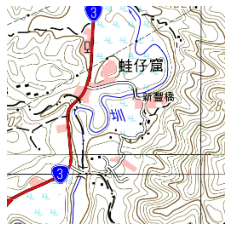

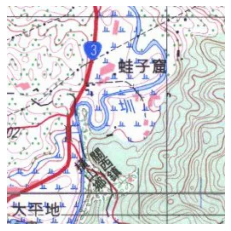

In [19]:
import random
imgidx = random.randint(0, len(datasetA)-1)
# imgidx = 2
# imgidx = 1496
# imgidx = 1229
# imgidx = 1229
print(f'imgidx: {imgidx}')

# 
# ld1it = enumerate(loader)
# for _ in range(skip):
#     next(ld1it)
# idx1, img1 = next(ld1it)
# ld2it = enumerate(loader_attr)
# for _ in range(skip):
#     next(ld2it)
# idx2, img2 = next(ld2it)
img1 = datasetA[imgidx]
img2 = datasetB[imgidx]
img1 = img1.view(1, *img1.size())
img2 = img2.view(1, *img2.size())

from saver import tensor2img
print(img1.shape)
img11 = tensor2img(img1)
img22 = tensor2img(img2)
plt.figure()
# plt.title('2017 map')
plt.axis('off')
plt.imshow(img11)
plt.figure()
# plt.title('2001 map')
plt.axis('off')
plt.imshow(img22)

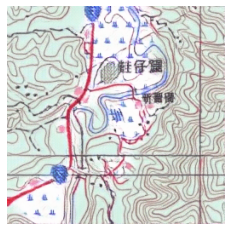

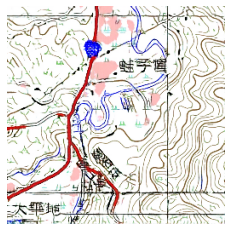

In [20]:
img1 = img1.cuda()
img2 = img2.cuda()

model.input_A = img1
model.mask_A = img1
model.input_B = img2

with torch.no_grad():
    # outimg_a2b = model.test_forward_transfer(img1, img2, a2b=True)
    # outimg_b2a = model.test_forward_transfer(img1, img2, a2b=False)
    model.forward()

outimg_a2b_ = tensor2img(model.fake_B_encoded)
# plt.title('2017 -> 2001 map')
plt.axis('off')
plt.imshow(outimg_a2b_)
plt.figure()
outimg_b2a_ = tensor2img(model.fake_A_encoded)
# plt.title('2001 -> 2017 map')
plt.axis('off')
plt.imshow(outimg_b2a_)

torch.Size([3, 256, 256])
torch.Size([256, 256])


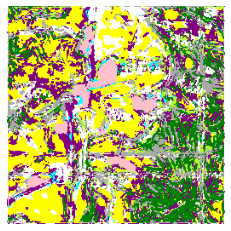

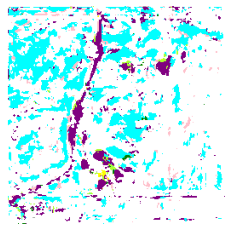

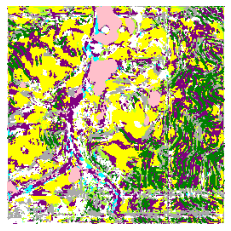

In [21]:
print(model.real_A_encoded[0].shape)
print(model.real_A_mask[0, 1].shape)
from torchvision.utils import draw_segmentation_masks
from PIL import Image
from PIL.ImageColor import getrgb
import torchvision.transforms as T

def showmask(mask):
    mask = torch.argmax(mask, dim=1).to(torch.uint8)
    mask = np.array(mask)
    mask = Image.fromarray(mask[0], mode='P')
    mask.putpalette(sum(map(getrgb, ['white', 'green', 'yellow', 'purple', 'greenyellow', 'cyan', 'pink', 'darkgrey']), ()))
    return mask

# with torch.no_grad():
#     img = torch.round((model.real_A_encoded[0] + 1) * 255).to(torch.uint8).cpu()
#     mask = (model.real_A_mask[0] > 0.5).cpu()

# show(draw_segmentation_masks(img, mask, alpha=1, colors=['white', 'green', 'yellow', 'purple', 'greenyellow', 'cyan', 'pink', 'darkgrey']))
plt.axis('off')
plt.imshow(showmask(model.real_A_mask.cpu()))
plt.figure()
plt.axis('off')
plt.imshow(showmask(model.real_B_mask.cpu()))
plt.figure()
plt.axis('off')
with torch.no_grad():
    outA, outs = model.enc_c.forward_a(model.fake_A_encoded)
    outA = model.enc_c_shared.forward_a(outA)
plt.imshow(showmask(model.unet_dec(outA, outs[:3][::-1]).cpu()))

In [7]:
model.z_attr_b.shape

torch.Size([1, 8])

In [8]:
# print(model.z_attr_b)
val_range = (-10.0, 10.0, 0.1)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(cont_sel=['A', 'B'], tdir=['AtoB', 'BtoA'], d1=val_range, d2=val_range, d3=val_range, d4=val_range, d5=val_range, d6=val_range, d7=val_range, d8=val_range)
def func(cont_sel='A', tdir='AtoB', d1=0.0, d2=0.0, d3=0.0, d4=0.0, d5=0.0, d6=0.0, d7=0.0, d8=0.0):
    with torch.no_grad():
        dirf = model.gen.forward_b if tdir == 'AtoB' else model.gen.forward_a
        print(model.z_attr_b if tdir == 'AtoB' else model.z_attr_a)
        # [[d1, d2, d3, d4, d5, d6, d7, d8]] = model.z_attr_b.cpu() 
        # outimg = model.gen.forward_b(model.z_content_a, model.z_attr_b)
        # outimg = model.gen.forward_b(model.z_content_a, model.z_attr_a)
        # outimg = model.gen.forward_b(model.z_content_a, torch.ones(model.z_attr_b.shape).cuda())
        # outimg = model.gen.forward_b(model.z_content_a, torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0]]).cuda())
        outimg = dirf(model.z_content_a if cont_sel == 'A' else model.z_content_b, torch.Tensor([[d1, d2, d3, d4, d5, d6, d7, d8]]).cuda())

    outimg_ = tensor2img(outimg)
    plt.imshow(outimg_)

interactive(children=(Dropdown(description='cont_sel', options=('A', 'B'), value='A'), Dropdown(description='t…

In [10]:
print(model.z_content_a.shape)
print(img1.shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 3, 256, 256])
